In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import pickle

from sklearn.linear_model import LinearRegression,ridge_regression,Lasso
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from sklearn import neighbors
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
import featuretools

In [2]:
data = pd.read_csv("vw.csv")
X = data.drop("price",axis=1)   ###independent columns
Y = data.loc[:,"price"]     ###Dependent col
data.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,T-Roc,2019,25000,Automatic,13904,Diesel,145,49.6,2.0
1,T-Roc,2019,26883,Automatic,4562,Diesel,145,49.6,2.0
2,T-Roc,2019,20000,Manual,7414,Diesel,145,50.4,2.0
3,T-Roc,2019,33492,Automatic,4825,Petrol,145,32.5,2.0
4,T-Roc,2019,22900,Semi-Auto,6500,Petrol,150,39.8,1.5


In [3]:
d_data = data.copy()

In [4]:
d_chk = [feature for feature in d_data.columns 
            if d_data[feature].dtype != object and d_data[feature].nunique() >= 7]
n_chk = [feature for feature in d_data.columns 
            if d_data[feature].dtype != object and d_data[feature].nunique() < 7]
cat_features = [feature for feature in d_data.columns 
                        if d_data[feature].dtype == object]

In [5]:
###removing outliers
def removeOutlier(data, d_features):
    
    
    for feature in d_features:
        ###Computing the upper and lower boudary using the interquantile range
        Q1 = data[feature].quantile(0.25)   ###Lower quantile
        Q3 = data[feature].quantile(0.75)   ###Upper quantile
        IQR = Q3 - Q1    ###Interquantile range
        lower_boundary = Q1 - (1.5 * IQR)
        upper_boundary = Q3 + (1.5 * IQR)

        ###Replacing the outlier with a nan value
        data.loc[data[feature] > upper_boundary, feature] = np.nan
        data.loc[data[feature] < lower_boundary, feature] = np.nan
        
    estimator = RandomForestRegressor(random_state=42)
        
    transformer = IterativeImputer(
        estimator=estimator, max_iter=10, random_state=42, verbose=1
    )
    
    transformer.fit(data[d_features])
    transformed_data = transformer.transform(data[d_features])
    return pd.DataFrame(transformed_data, columns=data[d_features].columns)

####removing the outliers and making a new dataframe
new_data = pd.concat([removeOutlier(d_data,d_chk),d_data[n_chk],d_data[cat_features]],axis=1)

[IterativeImputer] Completing matrix with shape (15157, 6)


C:\Users\PSALISHOL\anaconda3\lib\site-packages\alteryx_open_src_update_checker\functions.py:38: UserWarning: featuretools is out-of-date: installed == 0.27.1, latest == 1.1.0
  warnings.warn(msg)


[IterativeImputer] Change: 48010.52578370979, scaled tolerance: 70.438 
[IterativeImputer] Change: 15501.369999999999, scaled tolerance: 70.438 
[IterativeImputer] Change: 21803.740000000005, scaled tolerance: 70.438 
[IterativeImputer] Change: 11892.839999999998, scaled tolerance: 70.438 
[IterativeImputer] Change: 11882.08, scaled tolerance: 70.438 
[IterativeImputer] Change: 11580.020000000002, scaled tolerance: 70.438 
[IterativeImputer] Change: 11429.29, scaled tolerance: 70.438 
[IterativeImputer] Change: 11396.509999999998, scaled tolerance: 70.438 
[IterativeImputer] Change: 11762.33, scaled tolerance: 70.438 
[IterativeImputer] Change: 11693.140000000001, scaled tolerance: 70.438 


C:\Users\PSALISHOL\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


[IterativeImputer] Completing matrix with shape (15157, 6)


In [ ]:
dat_f = new_data.copy()
new_data1 = dat_f.drop("year",axis=1)
new_data1 = pd.concat([new_data1,data["year"]],axis=1)

In [6]:
new_data1.head()

,year,price,mileage,tax,mpg,engineSize,model,transmission,fuelType
0,2019.0,25000.0,13904.0,145.0,49.6,2.0,T-Roc,Automatic,Diesel
1,2019.0,26883.0,4562.0,145.0,49.6,2.0,T-Roc,Automatic,Diesel
2,2019.0,20000.0,7414.0,145.0,50.4,2.0,T-Roc,Manual,Diesel
3,2019.0,33492.0,4825.0,145.0,32.5,2.0,T-Roc,Automatic,Petrol
4,2019.0,22900.0,6500.0,150.0,39.8,1.5,T-Roc,Semi-Auto,Petrol


In [7]:
###feature feature encoding
def encoding(data):
    new_df = data.copy()
    features = ["model","transmission","fuelType","year"]
    
    encoded = LabelEncoder()
    for feature in features:
        new_df[feature] = encoded.fit_transform(new_df[feature])
       
    ###dropping year feature 
    new_df = new_df.drop("year", axis=1)
    
    return new_df
###Encoding the features
new_df = encoding(new_data)

In [8]:
new_df1 = new_df.copy()

In [9]:
###Standardizing the data
scaler = StandardScaler()
transformed = scaler.fit_transform(new_df1)
df_new = pd.DataFrame(transformed, columns=new_df.columns)

In [10]:
df_new.head()

,price,mileage,tax,mpg,engineSize,model,transmission,fuelType,year_maped
0,1.191968,-0.395009,0.516611,-0.336136,0.864902,0.909095,-1.855784,-1.162520,0.915394
1,1.459373,-0.934968,0.516611,-0.336136,0.864902,0.909095,-1.855784,-1.162520,0.915394
2,0.481917,-0.770125,0.516611,-0.255845,0.864902,0.909095,-0.198947,-1.162520,0.915394
3,2.397917,-0.919767,0.516611,-2.052357,0.864902,0.909095,-1.855784,0.872315,0.915394
4,0.893747,-0.822953,0.596274,-1.319701,-0.218101,0.909095,1.457889,0.872315,0.915394


In [11]:
new_d = df_new.copy()

In [12]:
###Creating list of the independent features 
ind_features = [feature for feature in new_d.columns if feature != "price"]
def createBaseline(data,feature, fit_regular= True):
    
    new_data = data.copy()
    ###Creating the dependent and the independent variable
    Y = new_data.loc[:,"price"]
    X = new_data.loc[:,feature]
    ###adding a constant to the independent variable
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    result = model.fit()

    ###printing the summary
    print(result.summary())

In [13]:
####Creating model Stats Summary using Ordinary Least Square Regression
createBaseline(data=new_d,feature=["model","transmission", 'mileage', 'fuelType', 'tax', 'mpg', 'engineSize'])

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     8641.
Date:                Sun, 07 Nov 2021   Prob (F-statistic):               0.00
Time:                        03:22:17   Log-Likelihood:                -9320.4
No. Observations:               15157   AIC:                         1.866e+04
Df Residuals:                   15149   BIC:                         1.872e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.429e-17      0.004  -6.68e-15   

In [33]:
from sklearn.metrics import r2_score
def linReg(data,val_size,test_size, save_model=False):
    df_new = data.copy()
    ###Splitting the set into dependent and independent set
    X = df_new.drop("price",axis=1)
    Y = df_new.loc[:,"price"]
    ###Creating the train split and test split
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=test_size, random_state=42)
    ###Creating Validation split
    x_train_t, x_val, y_train_t, y_val = train_test_split(x_train, y_train, test_size=val_size,random_state=42)

    linreg = LinearRegression()
    linreg.fit(x_train_t,y_train_t)
    y_pred = linreg.predict(x_val)      ##Validation
    y_pred1 = linreg.predict(x_test)    ##Test
    
    ###the metrics
    metrics = {
        "Accuracy Test" : np.round(100 - mean_absolute_percentage_error(y_test,y_pred1),3),
        "Accuracy Validation" :np.round(100 - mean_absolute_percentage_error(y_val,y_pred),3),
        "R2_score Test" : r2_score(y_test,y_pred1),
        "R2_score Validation": r2_score(y_val,y_pred),
        "RMSE Test": np.sqrt(mean_squared_error(y_test,y_pred1)),
        "RMSE Validation": np.sqrt(mean_squared_error(y_val,y_pred)),
        "MAE Test": mean_absolute_error(y_test,y_pred1),
        "MAE Validation": mean_absolute_error(y_val,y_pred)
    }
    metrics_linreg = pd.DataFrame.from_dict(metrics, orient="index", columns=["Score"])
    
    ###Saving the model
    if save_model is True:
        filepath = r"C:\Users\PSALISHOL\Documents\Ml projects\Car Price\Trained model\LinearRegressor"
        with open(filepath, "wb") as f:
            pickle.dump(object,f)
    print("LinearRegression")
    return metrics_linreg
        

###Training the model
linReg(new_d,test_size=0.3,val_size=0.3)

R2_score 0.8042168034125303
Validation r2_score 0.7834766249294086
Validation Root mean Squared error: 0.4516797380417686
Test Root mean Squared error: 0.4430173309356158


In [32]:
from sklearn.linear_model import SGDRegressor
def Sgdregressor(data,test_size=None, val_size=None, save_model=False):
    df_new = data.copy()
    df_new = df_new.drop("year_maped",axis=1)
    ###Splitting the set into dependent and independent set
    X = df_new.drop("price",axis=1)
    Y = df_new.loc[:,"price"]
    ###Creating the train split and test split
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=test_size, random_state=42)
    ###Creating Validation split
    x_train_t, x_val, y_train_t, y_val = train_test_split(x_train, y_train, test_size=val_size,random_state=42)
    sgdreg = SGDRegressor()
    sgdreg.fit(X,Y)
    y_pred = sgdreg.predict(x_val)
    y_pred1 = sgdreg.predict(x_test)
    
    ###Saving the model
    if save_model is True:
        with open("SBDRegressor", "wb") as f:
            pickle.dump(sgdreg,f)
    
    ###Creating Evaluation metrics
    metrics = {
        "Accuracy Test" : np.round(100 - mean_absolute_percentage_error(y_test,y_pred1),3),
        "Accuracy Validation" :np.round(100 - mean_absolute_percentage_error(y_val,y_pred),3),
        "R2_score Test" : r2_score(y_test,y_pred1),
        "R2_score Validation": r2_score(y_val,y_pred),
        "RMSE Test": np.sqrt(mean_squared_error(y_test,y_pred1)),
        "RMSE Validation": np.sqrt(mean_squared_error(y_val,y_pred)),
        "MAE Test": mean_absolute_error(y_test,y_pred1),
        "MAE Validation": mean_absolute_error(y_val,y_pred)
            }
    metrics_sgd  = pd.DataFrame.from_dict(metrics, orient="index", columns=["Score"])
    return metrics_sgd

Sgdregressor(new_d,test_size=0.3,val_size=0.3)

R2_score 0.8041503517294646
Validation r2_score 0.7835362243954923
Validation Root mean Squared error: 0.45161756987183843
Test Root mean Squared error: 0.44309250784092996


In [16]:
dk_data = new_d.copy()

R2_score 0.9056717555973287
Validation r2_score 0.8942579745552812
Validation Root mean Squared error: 0.31564726260403225
Test Root mean Squared error: 0.30750620567097686


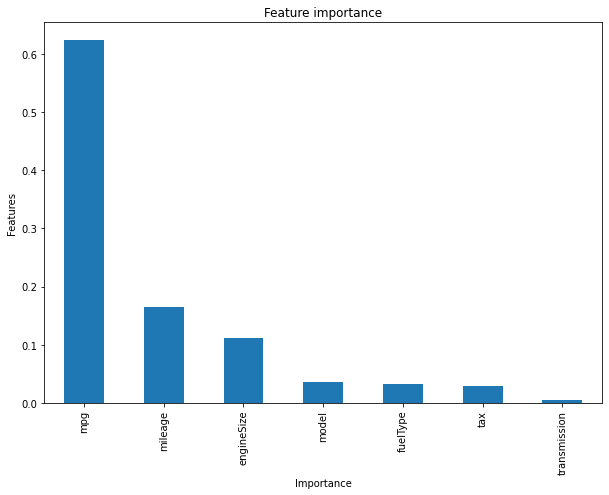

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

def Randomforestreg(data, plot_fea_imp=False,save_model=False, verbose_=None,n_job_=None):
    ###Condition to check
    if verbose_ is None:
        raise AttributeError("Must pass in either 0 or 1 for Verbose_ to generate the verbose")
    if n_job_ is None:
        raise AttributeError("Must pass in either 1 or -1 for n_job_ to  either train the model on core or not")
    
    r2_scor_mean = None
    dk_data = data.copy()
    ###Splitting the set into dependent and independent set
    X = dk_data.drop("price",axis=1)
    Y = dk_data.loc[:,"price"]
    ###Creating the train split and test split
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
    ###Creating Validation split
    x_train_t, x_val, y_train_t, y_val = train_test_split(x_train, y_train, test_size=0.3,random_state=42)

    
    """Tuning the Hyperparameters"""
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf,
                'bootstrap': bootstrap}

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, 
                                    param_distributions = random_grid, 
                                    n_iter = 15,
                                    cv = 5, 
                                    verbose=verbose_, 
                                    random_state=42,
                                    n_jobs = n_job_
                ).fit(x_train_t,y_train_t)
        
    estimator = rf_random.best_estimator_
    estimator.fit(x_train_t,y_train_t)
    y_pred = estimator.predict(x_val)
    y_pred1 = estimator.predict(x_test)
        
    ###Creating Evaluation metrics
    metrics = {
        "Accuracy Test" : np.round(100 - mean_absolute_percentage_error(y_test,y_pred1),3),
        "Accuracy Validation" :np.round(100 - mean_absolute_percentage_error(y_val,y_pred),3),
        "R2_score Test" : r2_score(y_test,y_pred1),
        "R2_score Validation": r2_score(y_val,y_pred),
        "RMSE Test": np.sqrt(mean_squared_error(y_test,y_pred1)),
        "RMSE Validation": np.sqrt(mean_squared_error(y_val,y_pred)),
        "MAE Test": mean_absolute_error(y_test,y_pred1),
        "MAE Validation": mean_absolute_error(y_val,y_pred)
            }
    metrics_randf  = pd.DataFrame.from_dict(metrics, orient="index", columns=["Score"])
    
    if plot_fea_imp is True:
        ##plotting the features
        feature_imp = pd.Series(estimator.feature_importances_, index=X.columns)
        ax = feature_imp.sort_values(ascending=False).plot(kind="bar", figsize=(10,7))
        plt.title("Feature importance")
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.show()
    
    
    ###Saving the model
    if save_model:
        filepath = r"C:\Users\PSALISHOL\Documents\Ml projects\Car Price\Trained model\RandomForestRegressor"
        with open(filepath, "wb") as f:
            pickle.dump(object,f)
        
    return metrics_randf

###Training the model
Randomforestreg(new_d,plot_fea_imp=True,verbose_=0,n_job_=-1,save_model=False)

### Randomforest seem to perform way better than the other linear model. Tuning the hyperparameters